# Demo

This notebook demonstrates some basic usage of the functions provided in this codebase. The other notebooks show real experiments and further functionality.

In [1]:
# importing packages
from systems.long_multirotor import LongTrajEnv

from typing import Union, Iterable, List
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.autonotebook import tqdm, trange
import optuna

from rl import learn_rl, transform_rl_policy, evaluate_rl, PPO, load_agent
from multirotor.simulation import Multirotor
from multirotor.helpers import DataLog
from multirotor.visualize import plot_datalog
from multirotor.controller import Controller
from multirotor.trajectories import Trajectory, GuidedTrajectory
from multirotor.controller.scurves import SCurveController
from systems.multirotor import MultirotorTrajEnv, VP
from multirotor.controller import (
    AltController, AltRateController,
    PosController, AttController,
    VelController, RateController,
    Controller
)
from scripts.opt_pidcontroller import (
    get_controller, make_disturbance_fn,
    apply_params as apply_params_pid, get_study as get_study_pid
)
from scripts.opt_multirotorenv import apply_params, get_study, get_established_controller

In [2]:
# Get the base environment, which is inside a rectangular bounding box
def get_env(params={}, scurve=False, **kwargs):  
    kw = dict(
        safety_radius=5, # how many meters in radius the bounding rectangle is
        vp=VP,get_controller_fn=lambda m: get_established_controller(m),
        steps_u=50, # steps between RL actions
        scaling_factor=0.5, # how to scale RL actions
        seed=0)
    return MultirotorTrajEnv(**kw)

In [3]:
env = LongTrajEnv(
    waypoints=np.array([[0,0,0], [20,0,0], [40,0,0], [60,0,0]]), # passing in manual waypoints, not ones generated with intermediate waypoints
    base_env = get_env(),
    initial_waypoints = np.array([[0,0,0], [20,0,0], [40,0,0], [60,0,0]])
)

done = False
env.reset()
log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                  other_vars=('reward',))
while not done:
    state, reward, done, _ = env.step([0,0,0]) # make no change in the desired waypoint, i.e., just use the PID. This is what the agent predicts.
    log.log(reward=reward)

/home/courseac/projects/supervisory-control/src/systems/multirotor.py:376: RuntimeWarning: invalid value encountered in scalar divide
  scalar_factor = np.dot(current_v, self._des_unit_vec) / np.dot(self._des_unit_vec, self._des_unit_vec)


Text(0, 0.5, 'Y (m)')

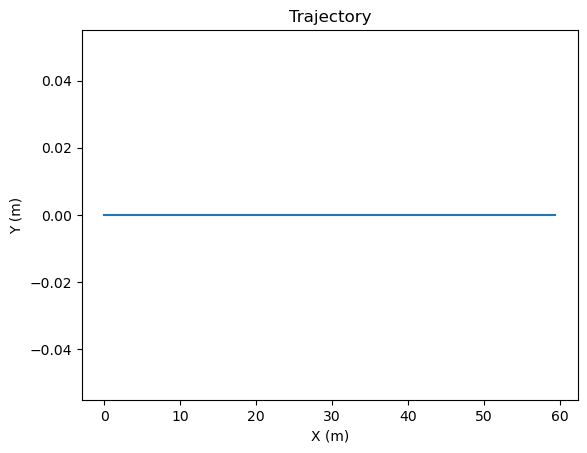

In [4]:
plt.title("Trajectory")
plt.plot(log.x, log.y)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")

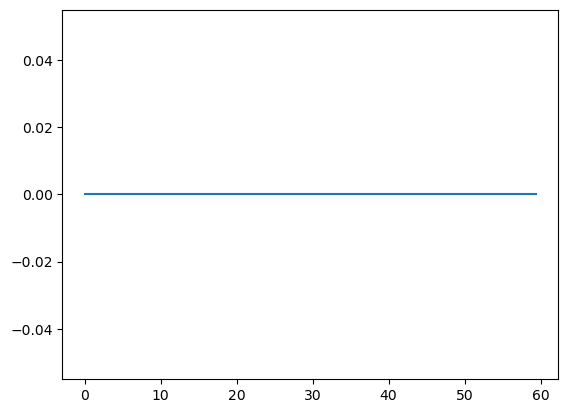

In [5]:
plt.plot(log.states[:,18], log.states[:,19])

In [6]:
square_np = np.array([[100,0,0], [100,100,0], [0,100,0], [0,0,0]]) # defining a square trajectory
big_square = Trajectory(None, points=square_np, resolution=200) # creating a Trajectory object here.
# Notice we specify the resolution. This defines the length of each rectangular bounding box that will be created. 
# For fairness, we set this to the length of each straight line (100) in all experiments with only the PID.
# The PID can be controller overshoots less in lower wind with these bounding boxes, but it flies slower. 

In [7]:
square_wpts = big_square.generate_trajectory(curr_pos=np.array([0,0,0])) # creates the intermediate waypoints

In [8]:
square_wpts

[array([0., 0., 0.]),
 array([100.,   0.,   0.]),
 array([100., 100.,   0.]),
 array([  0., 100.,   0.]),
 array([0., 0., 0.])]

In [9]:
env = LongTrajEnv(
    waypoints = square_wpts,
    base_env = get_env(),
    initial_waypoints = square_np # note the difference here from the example above
)
done = False
env.reset()
log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                  other_vars=('reward',))
while not done:
    state, reward, done, _ = env.step([0,0,0])
    log.log(reward=reward)

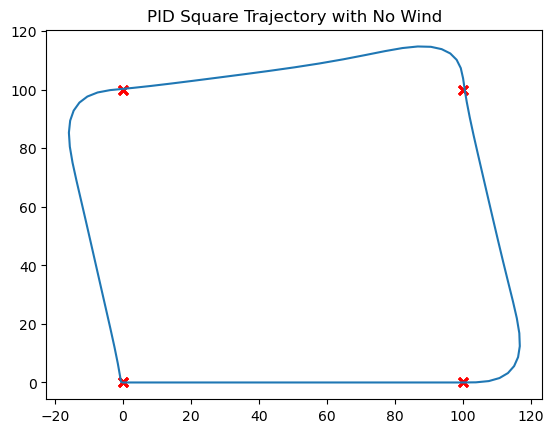

In [10]:
plt.title("PID Square Trajectory with No Wind")
plt.plot(log.x, log.y)
plt.scatter(log.target.position[:,0], log.target.position[:,1], marker='x', color='red')

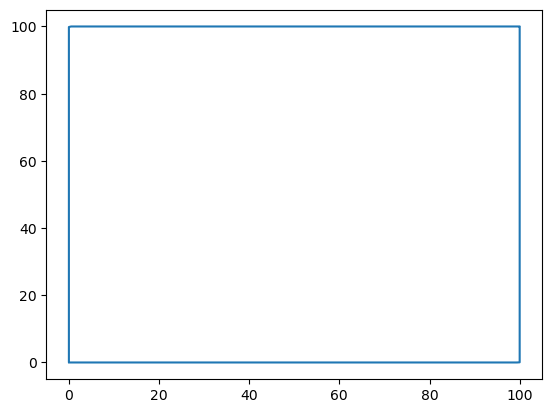

In [11]:
plt.plot(log.states[:,18], log.states[:,19])

In [ ]:
plt.plot(log.states[:,18]*500)

In [ ]:
plt.scatter(log.states[:,12], log.states[:,13], marker='x', c=range(len(log.states)), s=104)
plt.scatter(log.states[:,15], log.states[:,16], alpha=0.1, marker='o', c=range(len(log.states)), s=104)

In [ ]:
plt.plot(log.states[:,12])
plt.plot(log.states[:,13])

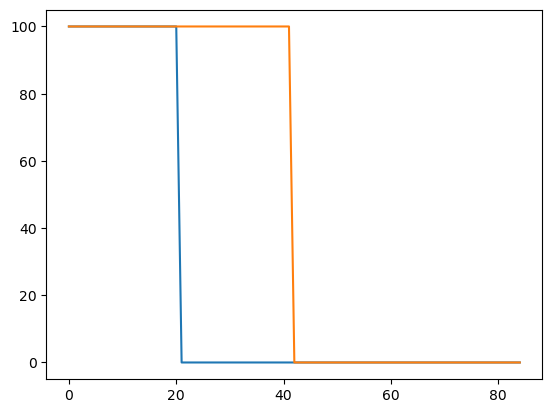

In [17]:
plt.plot(log.states[:,15])
plt.plot(log.states[:,16])

In [9]:
def get_tte(initial_pos: tuple, waypoints: np.ndarray, x: np.ndarray, y:np.ndarray, z:np.ndarray) -> np.ndarray:
        """
        Calculates the trajectory tracking error. 
        The distance between the current point and the vector between previous and next wp. Uses ||v1 x v2|| / ||v1||.

        Parameters
        ----------
        initial_pos : tuple  
            the initial position of the UAV.
        waypoints : np.ndarray 
            the reference positions at each point in time.
        x : np.ndarray 
            the x positions of the UAV.
        y : np.ndarray 
            the y positions of the UAV.
        z : np.ndarray
            the z positions of the UAV.

        Returns
        -------
        np.ndarray 
            the trajectory tracking error at each point in time.
        """
        ttes = []
        prev = initial_pos
        for i, waypoint in enumerate(waypoints):
            if i > 0 and not np.array_equal(waypoints[i-1], waypoints[i]):
                prev = waypoints[i-1]

            v1 = waypoint - prev
            v2 = np.array([x[i],y[i],z[i]]) - prev
            tte = np.linalg.norm(np.cross(v1, v2)) / np.linalg.norm(v1)
            ttes.append(tte)
                
        return np.array(ttes)

In [10]:
def completed_mission(waypoints: np.ndarray, x: np.ndarray, y: np.ndarray, z: np.ndarray, radius: float = 2.):
        for waypoint in waypoints:
            reached_waypoint = False

            for position in zip(x,y,z):
                dist = np.linalg.norm(waypoint - position)

                if dist <= radius:
                    reached_waypoint = True
                    break

            if not reached_waypoint:
                return False
            
        return True

To see how to add wind, see the `PID Wind Impact.ipynb` file.